In [82]:
from matplotlib import pyplot as plt

import numpy as np

from fit.mesh.mesh import Mesh
from fit.solver.solve_poisson import solve_poisson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
## Generate mesh
xmesh = np.linspace(0, 10, 10)
ymesh = np.linspace(0, 10, 10)
zmesh = np.linspace(0, 10, 2)
msh = Mesh(xmesh, ymesh, zmesh)

In [96]:
## Set boundary conditions  TODO: Fix bc
bc = np.full(msh.np, np.nan)
idx_bc_1 = [msh.idx(0, j, 0) for j in range(10)]
idx_bc_2 = [msh.idx(9, j, 0) for j in range(10)]
idx_bc_3 = [msh.idx(0, j, 1) for j in range(10)]
idx_bc_4 = [msh.idx(9, j, 1) for j in range(10)]
bc[idx_bc_1] = 0
bc[idx_bc_2] = 1
bc[idx_bc_3] = 1
bc[idx_bc_4] = 1

In [97]:
## Solve system
eps = 8.854e-12
phi = solve_poisson(msh, np.zeros(msh.np), eps, bc)
print(phi)

(160, 160)
160
[0.         0.         0.08832667 0.         0.09429115 0.
 0.11827473 0.         0.1362421  1.         0.         0.
 0.08852565 0.         0.0940687  0.         0.118349   0.
 0.13814593 1.         0.         0.         0.08892942 0.
 0.09361491 0.         0.11847863 0.         0.14199966 1.
 0.         0.         0.08954982 0.         0.09291202 0.
 0.11862483 0.         0.14789686 1.         0.         0.
 0.0904051  0.         0.09193319 0.         0.11872709 0.
 0.15598132 1.         0.         0.         0.09152054 0.
 0.09064244 0.         0.11870021 0.         0.16645142 1.
 0.         0.         0.0929293  0.         0.08899445 0.
 0.1184302  0.         0.17956598 1.         0.         0.
 0.09467345 0.         0.08693448 0.         0.11776883 0.
 0.19565218 1.         0.         0.         0.09680534 0.
 0.0843983  0.         0.11652661 0.         0.21511536 1.
 0.         0.         0.0993892  0.         0.0813123  0.
 0.11446389 0.         0.23845143 1.     

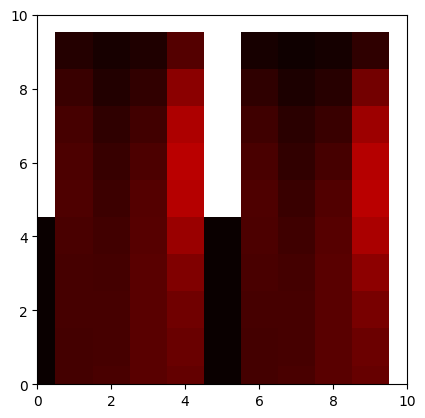

In [99]:
## Plot solution
phi_plot = np.reshape(phi, (msh.nx, msh.ny, msh.nz))  # TODO: Fix plot
plt.imshow(phi_plot[:,:,0], cmap='hot')
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.show()